In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tqdm
import pandas as pd
import dataset_utils
import torchxrayvision as xrv

In [18]:
model = xrv.models.get_model(weights="densenet121-res224-all").cuda()

In [29]:
model = xrv.models.get_model(weights="resnet50-res512-all").cuda()

In [24]:
model = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [3]:
model = xrv.baseline_models.chexpert.DenseNet(
    weights_zip="/home/users/joecohen/scratch/chexpert/chexpert_weights.zip", 
    num_models=1
    ).cuda()

Loading weights ('Atelectasis', 'Edema'): 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]
Loading weights ('Cardiomegaly', 'Pleural Effusion'): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
Loading weights ('Consolidation',): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


In [19]:
def extract_features(model: torch.nn.Module, dataset: torch.utils.data.Dataset, cuda=True):

    dl = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        num_workers=1, 
        pin_memory=cuda,
    )
    
    d_feats = []
    with torch.inference_mode():
        for i, batch in enumerate(tqdm.tqdm(dl)):
            imgs = batch["img"]
            if cuda:
                imgs = imgs.cuda()
            if hasattr(model, "features2"):
                feats = model.features2(imgs)
            else:
                feats = model.features(imgs)
            feats = feats.detach().cpu().numpy()
            feats = feats.reshape(len(feats),-1)
            d_feats.append(feats)
    d_feats = np.concatenate(d_feats)
    return d_feats


In [5]:
pathos = ["Effusion", "Fibrosis", "Hernia", "Edema"]

In [6]:
dataset = dataset_utils.get_data("nih-pc", pathologies=pathos)

{'Emphysema', 'Support Devices', 'Costophrenic Angle Blunting', 'Aortic Atheromatosis', 'Tuberculosis', 'Nodule', 'Hilar Enlargement', 'Consolidation', 'Mass', 'Scoliosis', 'Tube', 'Cardiomegaly', 'Pleural_Thickening', 'Bronchiectasis', 'Atelectasis', 'Pneumothorax', 'Air Trapping', 'Granuloma', 'Hemidiaphragm Elevation', 'Pneumonia', 'Fracture', 'Aortic Elongation', 'Infiltration', 'Flattened Diaphragm'} will be dropped
{'Emphysema', 'Pleural_Thickening', 'Infiltration', 'Atelectasis', 'Pneumothorax', 'Nodule', 'Consolidation', 'Mass', 'Pneumonia', 'Cardiomegaly'} will be dropped
['Edema', 'Effusion', 'Fibrosis', 'Hernia']


In [7]:
# select samples with one element
dataset = xrv.datasets.SubsetDataset(dataset, idxs=np.where(np.sum(dataset.labels, axis=1) == 1)[0])

In [8]:
dataset

{'Edema': {0.0: 20051, 1.0: 2015},
 'Effusion': {0.0: 5805, 1.0: 16261},
 'Fibrosis': {0.0: 19948, 1.0: 2118},
 'Hernia': {0.0: 20394, 1.0: 1672}}


SubsetDataset num_samples=22066
└ of MergeDataset num_samples=206945
  ├0 PC_Dataset num_samples=94825 views=['PA', 'AP'] data_aug=None
  └1 NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
  

In [9]:
# load equal number of samples of each pathology
num_samples = 512
idxs = []
for path in pathos:
    path_idxs = dataset.labels[:,dataset.pathologies.index(path)] == 1
    np.random.seed(0)
    idxs.append(np.random.choice(np.where(path_idxs)[0], num_samples, replace=False))
idxs = np.concatenate(idxs)

In [10]:
dataset = xrv.datasets.SubsetDataset(dataset, idxs=idxs)

In [11]:
dataset

{'Edema': {0.0: 1536, 1.0: 512},
 'Effusion': {0.0: 1536, 1.0: 512},
 'Fibrosis': {0.0: 1536, 1.0: 512},
 'Hernia': {0.0: 1536, 1.0: 512}}


SubsetDataset num_samples=2048
└ of SubsetDataset num_samples=22066
  └ of MergeDataset num_samples=206945
    ├0 PC_Dataset num_samples=94825 views=['PA', 'AP'] data_aug=None
    └1 NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
    

In [30]:
data = extract_features(model, dataset)

100%|██████████| 32/32 [01:34<00:00,  2.96s/it]


In [31]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2, random_state=54).fit_transform(data)
# X_embedded.shape

In [32]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import umap
    reducer = umap.UMAP()
    X_embedded = reducer.fit_transform(data)
    X_embedded.shape

xrv-resnet-resnet50-res512-all__dim_2048_


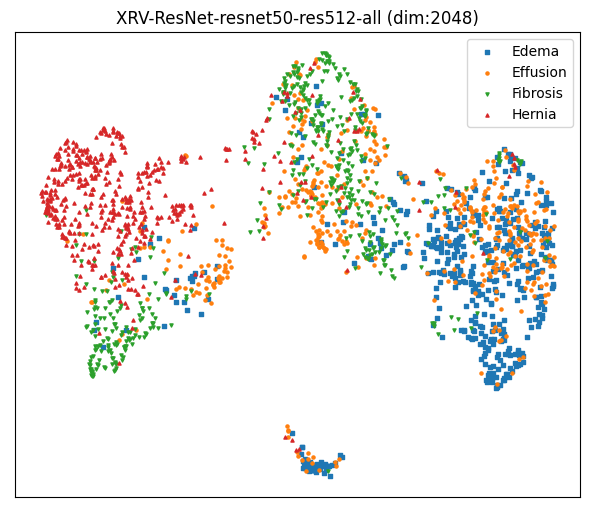

In [33]:
plt.figure(0, figsize=(6, 5), dpi=100)
markers = ["s", "o", "v", "^", "P", "x", "*"]
for i, idx in enumerate(sorted(np.unique(np.argmax(dataset.labels, axis=1)))):
    name = dataset.pathologies[idx]
    
    mask = np.argmax(dataset.labels, axis=1) == idx
    
    plt.scatter(X_embedded[:,0][mask], 
                X_embedded[:,1][mask], 
                s=5,
                label=name,
                marker=markers[i]
                );
plt.legend();
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()
plt.title(f'{model} (dim:{data.shape[1]})');
fname = (f'{model} (dim:{data.shape[1]})').lower()
for rm in [" ", "(", ")", ":"]:
    fname = fname.replace(rm, "_")
print(fname)

xrv-densenet121-densenet121-res224-all__dim_1024_


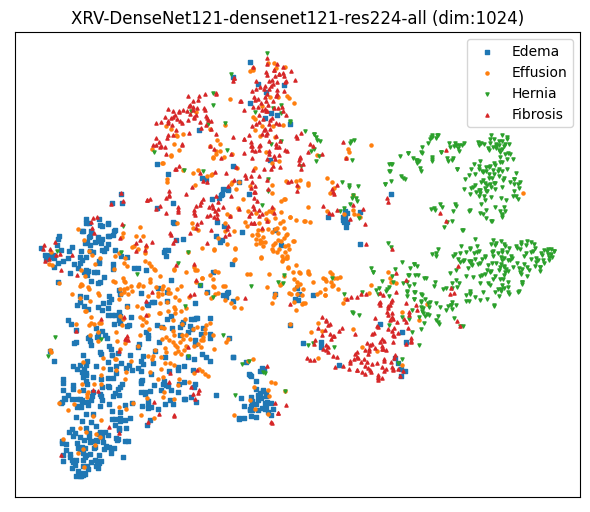

In [67]:
plt.figure(0, figsize=(6, 5), dpi=100)
markers = ["s", "o", "v", "^", "P", "x", "*"]
for i, idx in enumerate(sorted(np.unique(np.argmax(dataset.labels, axis=1)))):
    name = dataset.pathologies[idx]
    
    mask = np.argmax(dataset.labels, axis=1) == idx
    
    plt.scatter(X_embedded[:,0][mask], 
                X_embedded[:,1][mask], 
                s=5,
                label=name,
                marker=markers[i]
                );
plt.legend();
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()
plt.title(f'{model} (dim:{data.shape[1]})');
fname = (f'{model} (dim:{data.shape[1]})').lower()
for rm in [" ", "(", ")", ":"]:
    fname = fname.replace(rm, "_")
print(fname)